In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Importation des données

In [2]:
df = pd.read_csv('nba_logreg.csv')

In [3]:
print(df.shape)

(1340, 21)


In [4]:
df.isna().sum()

Name            0
GP              0
MIN             0
PTS             0
FGM             0
FGA             0
FG%             0
3P Made         0
3PA             0
3P%            11
FTM             0
FTA             0
FT%             0
OREB            0
DREB            0
REB             0
AST             0
STL             0
BLK             0
TOV             0
TARGET_5Yrs     0
dtype: int64

Les seules valeurs manquantes correspondent au cas où un joueur n'a tiré aucun 3 points durant la saison. On peut donc remplacer ces valeurs par 0.

In [5]:
df.fillna(0,inplace=True)

## Features Engineering

Les variables à disposition sont les suivantes : 
- GP : nombre de matchs joués
- MIN : minutes jouées par match
- PTS : points par match
- FGM : nombre de tirs réussis par match
- FGA : nombre de tirs tentés par match
- FG% : pourcentage au tir
- 3PM, 3PA, 3P% : nombre de tirs à 3 points réussis, tentés et pourcentage à 3 points
- FTM, FTA, FT% : nombre de lancers francs marqués, tentés et pourcentage
- OREB, DREB , REB : nombre de rebonds offensifs, défensifs et total par match
- AST : nombre de passes décisives par match
- STL : nombre d'interceptions par match
- BLK : nombre de contres par match
- TOV : nombre de pertes de balle par match

On constate que toutes les variables données sont des statistiques par match. Or, utiliser les valeurs par match va entrainer un biais envers les joueurs jouant le plus de minutes par match, comme on peut le constater en observant les coefficients de correlation :

In [6]:
df.corr()['MIN']

GP             0.590240
MIN            1.000000
PTS            0.911822
FGM            0.903060
FGA            0.910247
FG%            0.203901
3P Made        0.389920
3PA            0.403258
3P%            0.168070
FTM            0.791000
FTA            0.779609
FT%            0.239878
OREB           0.573062
DREB           0.745513
REB            0.709707
AST            0.629015
STL            0.757034
BLK            0.399088
TOV            0.826500
TARGET_5Yrs    0.317805
Name: MIN, dtype: float64

On voit en effet que toutes les statistiques sont fortement corrélées avec les minutes jouées par match. J'ai donc décidé d'utiliser les statistiques par minute plutôt que par match afin de se débarasser de ce biais.

In [7]:
# Transformation en statistiques/minutes
to_change = ['PTS', 'FGM', 'FGA', '3P Made', '3PA', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK','TOV']

for col in to_change:
    df[col] = df[col]/df['MIN']

In [8]:
df.corr()['MIN']

GP             0.590240
MIN            1.000000
PTS            0.336164
FGM            0.311420
FGA            0.209977
FG%            0.203901
3P Made        0.086662
3PA            0.038738
3P%            0.168070
FTM            0.193622
FTA            0.113862
FT%            0.239878
OREB          -0.065761
DREB           0.080807
REB            0.019602
AST            0.145060
STL            0.061514
BLK           -0.003628
TOV           -0.027111
TARGET_5Yrs    0.317805
Name: MIN, dtype: float64

On constate bien que la correlation de la plupart des statistiques a nettement diminué.

J'ai décidé d'ajouter la variable d'efficiency "EFF", telle qu'elle est définie ici : https://www.nbastuffer.com/analytics101/nba-efficiency/ .

In [9]:
df['EFF'] = df['PTS'] + df['REB'] + df['AST'] + df['STL'] + df['BLK'] - (df['FGA']-df['FGM']) - (df['FTA']-df['FTM']) - df['TOV']

Observons maintenant la distribution de chaque variable :

In [10]:
features = ['GP','MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P Made', '3PA',
       '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
       'TOV','EFF']

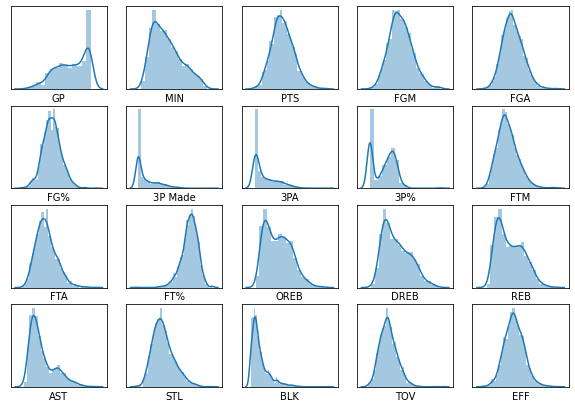

In [11]:
plt.figure(figsize=(10,7))

i=1
for col in features:
    plt.subplot(4,5,i)
    sns.distplot(df[col])
    plt.xticks([])
    plt.yticks([])
    i += 1 

Pour me rapprocher d'une distribution normale, je vais transformer certaines des variables en prenant le log (ou la racine carrée quand la variable peut valoir 0).

In [12]:
for col in ['DREB','REB','TOV']:
    df[col]=np.log(df[col])

for col in ['OREB','AST','STL','BLK']:
    df[col]=np.sqrt(df[col])

Pour visualiser l'influence de chaque variable sur "TARGET_5Yrs", le label à prédire, je plot la distribution de chaque variable en séparant les cas positifs des négatifs. J'affiche aussi le coefficient de correlation entre la variable et TARGET_5Yrs.

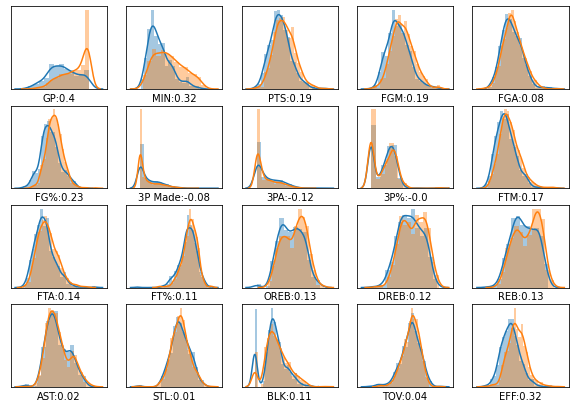

In [13]:
plt.figure(figsize=(10,7))

i=1
for col in features:
    plt.subplot(4,5,i)
    sns.distplot(df[df['TARGET_5Yrs']==0][col])
    sns.distplot(df[df['TARGET_5Yrs']==1][col])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("{}:{}".format(col, round(df.corr()['TARGET_5Yrs'][col],2)))
    i += 1 

On voit qu'à priori, les variables les plus influentes sont le nombre de matchs joués, le nombre de minutes jouées par match, l'efficiency, le pourcentage au tir et le nombre de points par minute.

## Fonction de scoring

Commençons par regarder la variable qu'on cherche à prédire, "TARGET_5Yrs" :

Text(0.5, 1.0, 'Répartition des classes : 0 : 38.0% , 1 : 62.0% ')

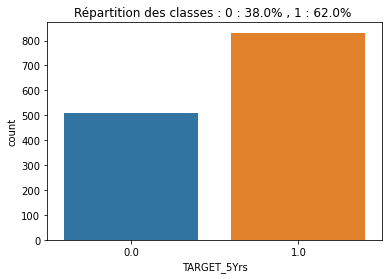

In [14]:
sns.countplot(df['TARGET_5Yrs'])
p_1 = round(100*df['TARGET_5Yrs'].sum()/df.shape[0],1)
plt.title('Répartition des classes : 0 : {}% , 1 : {}% '.format(100-p_1, p_1))

On peut voir que la répartition de cette variable est assez équilibrée, avec 38% de cas "négatifs", et 62% de cas "positifs".

Par défaut, la fonction de scoring proposée est le recall, qui quantifie la capacité de l'algorithme à trouver tout les cas positifs. Ce choix de scoring est justifié si l'on considère une équipe dont la priorité est de ne manquer aucun joueur intéressant, même si cela entraine beaucoup de "faux positifs".

Si on considère une autre stratégie d'équipe, pour qui le plus important est de signer exclusivement des joueurs intéressants, et de minimiser les "faux positifs", alors il serait préférable d'utiliser une fonction de scoring en precision. 

Enfin, on peut utiliser le score F1 ou l'accuracy pour une équipe dont l'objectif est plus équilibré, i.e. pour qui signer des joueurs intéressants est aussi important que d'éviter les joueurs faussement prometteurs.

J'ai donc décidé d'ajouter la précision, l'accuracy et le score F1 à la fonction d'évaluation, pour pouvoir évaluer les algorithmes avec plus de nuance (en utilisant uniquement le recall, il est possible d'avoir un score parfait avec un classifieur prédisant toujours 1 ).

In [15]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score

# fonction pour afficher la matrice de confusion
def display_matrix(matrix):
    group_names = ['TN','FP','FN','TP']
    group_counts = ["{0:0.0f}".format(value) for value in matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in matrix.flatten()/np.sum(matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues')

# Fonction score_classifier modifiée
def score_classifier(dataset,classifier,labels,disp=True):

    """
    performs 5 random trainings/tests to build a confusion matrix and prints results with precision and recall scores
    :param dataset: the dataset to work on
    :param classifier: the classifier to use
    :param labels: the labels used for training and validation
    :return:
    """

    kf = KFold(n_splits=5,random_state=50,shuffle=True)
    confusion_mat = np.zeros((2,2))
    scores = {'recall' : 0,
              'precision' : 0,
              'accuracy' : 0,
              'f1' : 0 }
    
    for training_ids,test_ids in kf.split(dataset):
        
        training_set = dataset[training_ids]
        training_labels = labels[training_ids]
        test_set = dataset[test_ids]
        test_labels = labels[test_ids]
        
        classifier.fit(training_set,training_labels)
        predicted_labels = classifier.predict(test_set)
        
        confusion_mat+=confusion_matrix(test_labels,predicted_labels)
        
        scores['recall'] += recall_score(test_labels, predicted_labels)
        scores['precision'] += precision_score(test_labels, predicted_labels)
        scores['accuracy'] += accuracy_score(test_labels, predicted_labels)
        scores['f1'] += f1_score(test_labels, predicted_labels)
    
    for score in scores:
        scores[score]/=5
    
    if disp == True:
        display_matrix(confusion_mat)
    print(scores)

## Modèles predictifs

Etant donné le faible nombre de données (1340), j'ai décidé de tester uniquement des modèles très simples et robustes, et d'éviter des modèles plus complexes de bagging/boosting qui n'apporteraient rien ici.

In [16]:
from sklearn.preprocessing import MinMaxScaler

# extract names, labels, features names and values
names = df['Name'].values.tolist() # players names
labels = df['TARGET_5Yrs'].values # labels
paramset = df.drop(['TARGET_5Yrs','Name'],axis=1).columns.values
df_vals = df.drop(['TARGET_5Yrs','Name'],axis=1).values

# normalize dataset
scaler = MinMaxScaler()
scaler.fit(df_vals)
X = scaler.transform(df_vals)

### - Logistic Regression

{'recall': 0.8353471007637147, 'precision': 0.7355998009527795, 'accuracy': 0.7111940298507463, 'f1': 0.7813973651070426}


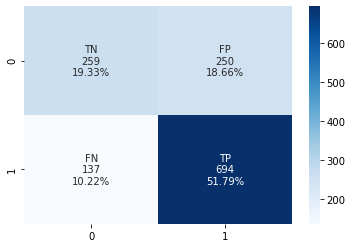

In [17]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

score_classifier(X,lr,labels)

In [18]:
df['lr_prediction'] = lr.predict(X)

index_miss_lr = df[df['lr_prediction'] != df['TARGET_5Yrs']].index.values

df = df.drop('lr_prediction',axis=1)

### - SVM

{'recall': 0.8297577570677774, 'precision': 0.7287350249394638, 'accuracy': 0.7022388059701493, 'f1': 0.7749669656764491}


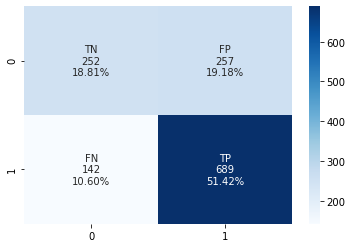

In [19]:
from sklearn.svm import SVC

svm = SVC()

score_classifier(X,svm,labels)

### - Naive Bayes

{'recall': 0.7354614501121018, 'precision': 0.7547589917163462, 'accuracy': 0.6880597014925374, 'f1': 0.7446053905371549}


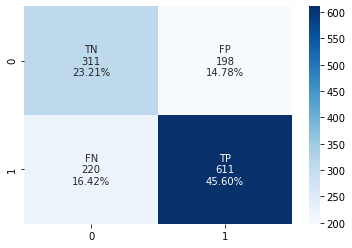

In [20]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

score_classifier(X,nb,labels)

### - Decision Tree

In [21]:
from sklearn.tree import DecisionTreeClassifier

for depth in [1,2,3,5]:
    dt = DecisionTreeClassifier(max_depth=depth)
    
    score_classifier(X,dt,labels,False)

{'recall': 0.6750255641862087, 'precision': 0.769711551978467, 'accuracy': 0.6708955223880597, 'f1': 0.7171767621133476}
{'recall': 0.809091782959275, 'precision': 0.7184064030479147, 'accuracy': 0.6828358208955224, 'f1': 0.7590527309934146}
{'recall': 0.7324932452280546, 'precision': 0.7480720853846405, 'accuracy': 0.6813432835820896, 'f1': 0.7395325740225092}
{'recall': 0.7485960966785987, 'precision': 0.7222868933046209, 'accuracy': 0.6656716417910447, 'f1': 0.7348448419456572}


### - Ensembling

{'recall': 0.8436709189217726, 'precision': 0.7265958315693427, 'accuracy': 0.7059701492537312, 'f1': 0.7800931946497893}


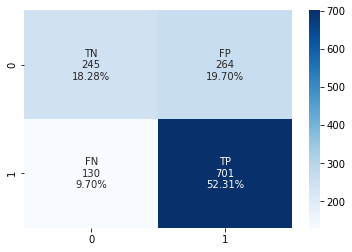

In [22]:
from sklearn.ensemble import VotingClassifier, StackingClassifier

clf1 = LogisticRegression()
clf2 = GaussianNB()

eclf = StackingClassifier(estimators=[('lr',clf1),('nb',clf2)])
score_classifier(X,eclf,labels)

Je vais utiliser le dernier modèle testé pour le deploiement, etant donné que c'est celui qui a le meilleur recall.

In [23]:
# Fit du modèle sur l'ensemble des données

clf1 = LogisticRegression()
clf2 = GaussianNB()
eclf = StackingClassifier(estimators=[('lr',clf1),('nb',clf2)])

eclf.fit(X,labels)

StackingClassifier(estimators=[('lr', LogisticRegression()),
                               ('nb', GaussianNB())])

In [24]:
import joblib
joblib.dump(eclf, 'classifier.joblib')

['classifier.joblib']

In [25]:
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

## Test du webservice

J'ai déployé l'algorithme sur Heroku, en utilisant Flask. L'application est accessible à l'adresse https://testmpdata.herokuapp.com/ .

Ci-dessous un exemple d'utilisation de l'API :

In [201]:
url = "https://testmpdata.herokuapp.com/"

In [202]:
from random import randint

ind = randint(0,1300)
df = pd.read_csv('nba_logreg.csv', dtype=str)
labels = df['TARGET_5Yrs']
df = df.drop('TARGET_5Yrs',axis=1)
data = dict(df.iloc[ind])
label = labels[ind]

In [203]:
data

{'Name': 'Bernard Thompson',
 'GP': '59',
 'MIN': '9.1',
 'PTS': '3.3',
 'FGM': '1.3',
 'FGA': '3.6',
 'FG%': '37.3',
 '3P Made': '0.0',
 '3PA': '0.1',
 '3P%': '0.0',
 'FTM': '0.7',
 'FTA': '0.9',
 'FT%': '76.5',
 'OREB': '0.6',
 'DREB': '0.7',
 'REB': '1.3',
 'AST': '0.9',
 'STL': '0.5',
 'BLK': '0.2',
 'TOV': '0.6'}

In [204]:
import requests
import json
send = requests.post(url,json = data)

In [205]:
print("Prediction : {}".format(send.json()['prediction']))
print("Vrai label : {}".format(label))

Prediction : [1.0]
Vrai label : 1.0
